In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn import DataParallel
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
import numpy as np
import time
import copy
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# Check available devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    multi_gpu = True
else:
    print("Using single GPU")
    multi_gpu = False

Using device: cuda
Using 2 GPUs!


In [13]:
# Define batch size and other hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 15

In [4]:
# Define data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomRotation(5),  # Add slight rotation for augmentation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalized for grayscale
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalized for grayscale
])


In [15]:
# Set dataset path
dataset_path = '/kaggle/input/devanagaridataset'

# Load full dataset (no transforms yet)
full_dataset = datasets.ImageFolder(root=dataset_path)

# Get number of classes
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {full_dataset.classes}")

# Step 1: Split into 80% Train, 20% Test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1337))

# Step 2: Split the train dataset into 85% Train and 15% Validation
train_sub_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_sub_size
train_dataset, val_dataset = random_split(train_dataset, [train_sub_size, val_size], generator=torch.Generator().manual_seed(1337))

# Apply transforms separately
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

Number of classes: 41
Class names: ['CC_1', 'CC_10', 'CC_11', 'CC_12', 'CC_13', 'CC_14', 'CC_15', 'CC_16', 'CC_17', 'CC_18', 'CC_19', 'CC_2', 'CC_20', 'CC_21', 'CC_22', 'CC_23', 'CC_24', 'CC_25', 'CC_26', 'CC_27', 'CC_28', 'CC_29', 'CC_3', 'CC_30', 'CC_31', 'CC_32', 'CC_33', 'CC_34', 'CC_35', 'CC_36', 'CC_37', 'CC_38', 'CC_39', 'CC_4', 'CC_40', 'CC_41', 'CC_5', 'CC_6', 'CC_7', 'CC_8', 'CC_9']


In [16]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 34013
Validation dataset size: 6003
Test dataset size: 10004


In [18]:
# Load the pretrained ResNet50 model - good balance between depth and performance for OCR
model = models.resnet50(pretrained=True)
print("ResNet50 model loaded successfully")

# Modify first conv layer to accept grayscale input (1 channel instead of 3)
original_conv1 = model.conv1
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Transfer weights from pretrained model's first layer to new conv layer by averaging channels
with torch.no_grad():
    new_weight = original_conv1.weight.data.mean(dim=1, keepdim=True)
    model.conv1.weight.data = new_weight

# Modify final fully connected layer for our number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move model to device
model = model.to(device)

# Use DataParallel for multi-GPU training
if multi_gpu:
    model = DataParallel(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

ResNet50 model loaded successfully


In [19]:
# Function to train one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()


In [20]:
# Function to validate the model
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples * 100
    
    return epoch_loss, epoch_acc.item()

In [11]:
# Lists to track progress
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0.0


In [21]:
# Training loop
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Step the scheduler
    scheduler.step()
    
    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Record statistics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print statistics
    print(f'Epoch {epoch+1}/{EPOCHS} | Time: {epoch_time:.0f}s')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)

Starting training for 15 epochs...
Epoch 1/15 | Time: 229s
Train Loss: 0.8867 | Train Acc: 81.81%
Val Loss: 0.0795 | Val Acc: 98.35%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 2/15 | Time: 233s
Train Loss: 0.0885 | Train Acc: 98.17%
Val Loss: 0.0519 | Val Acc: 98.53%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/15 | Time: 235s
Train Loss: 0.0441 | Train Acc: 99.11%
Val Loss: 0.0429 | Val Acc: 98.77%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 4/15 | Time: 234s
Train Loss: 0.0275 | Train Acc: 99.51%
Val Loss: 0.0459 | Val Acc: 98.78%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/15 | Time: 234s
Train Loss: 0.0174 | Train Acc: 99.70%
Val Loss: 0.0425 | Val Acc: 98.82%
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/15 | Time: 234s
Train Loss: 0.0143 | Train Acc: 99.74%
Val Loss: 0.0481 | Val Acc: 98.67%
Le

In [22]:
# Load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [23]:

total_time = time.time() - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy: {best_acc:.2f}%')

Training complete in 61m 14s
Best Validation Accuracy: 99.07%


In [24]:
# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 99.12%


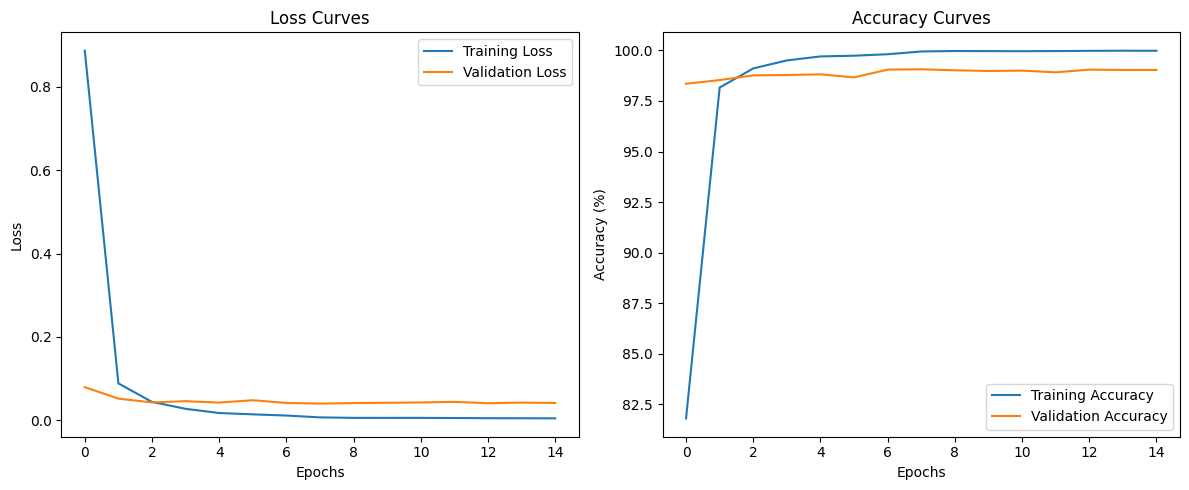

In [25]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')

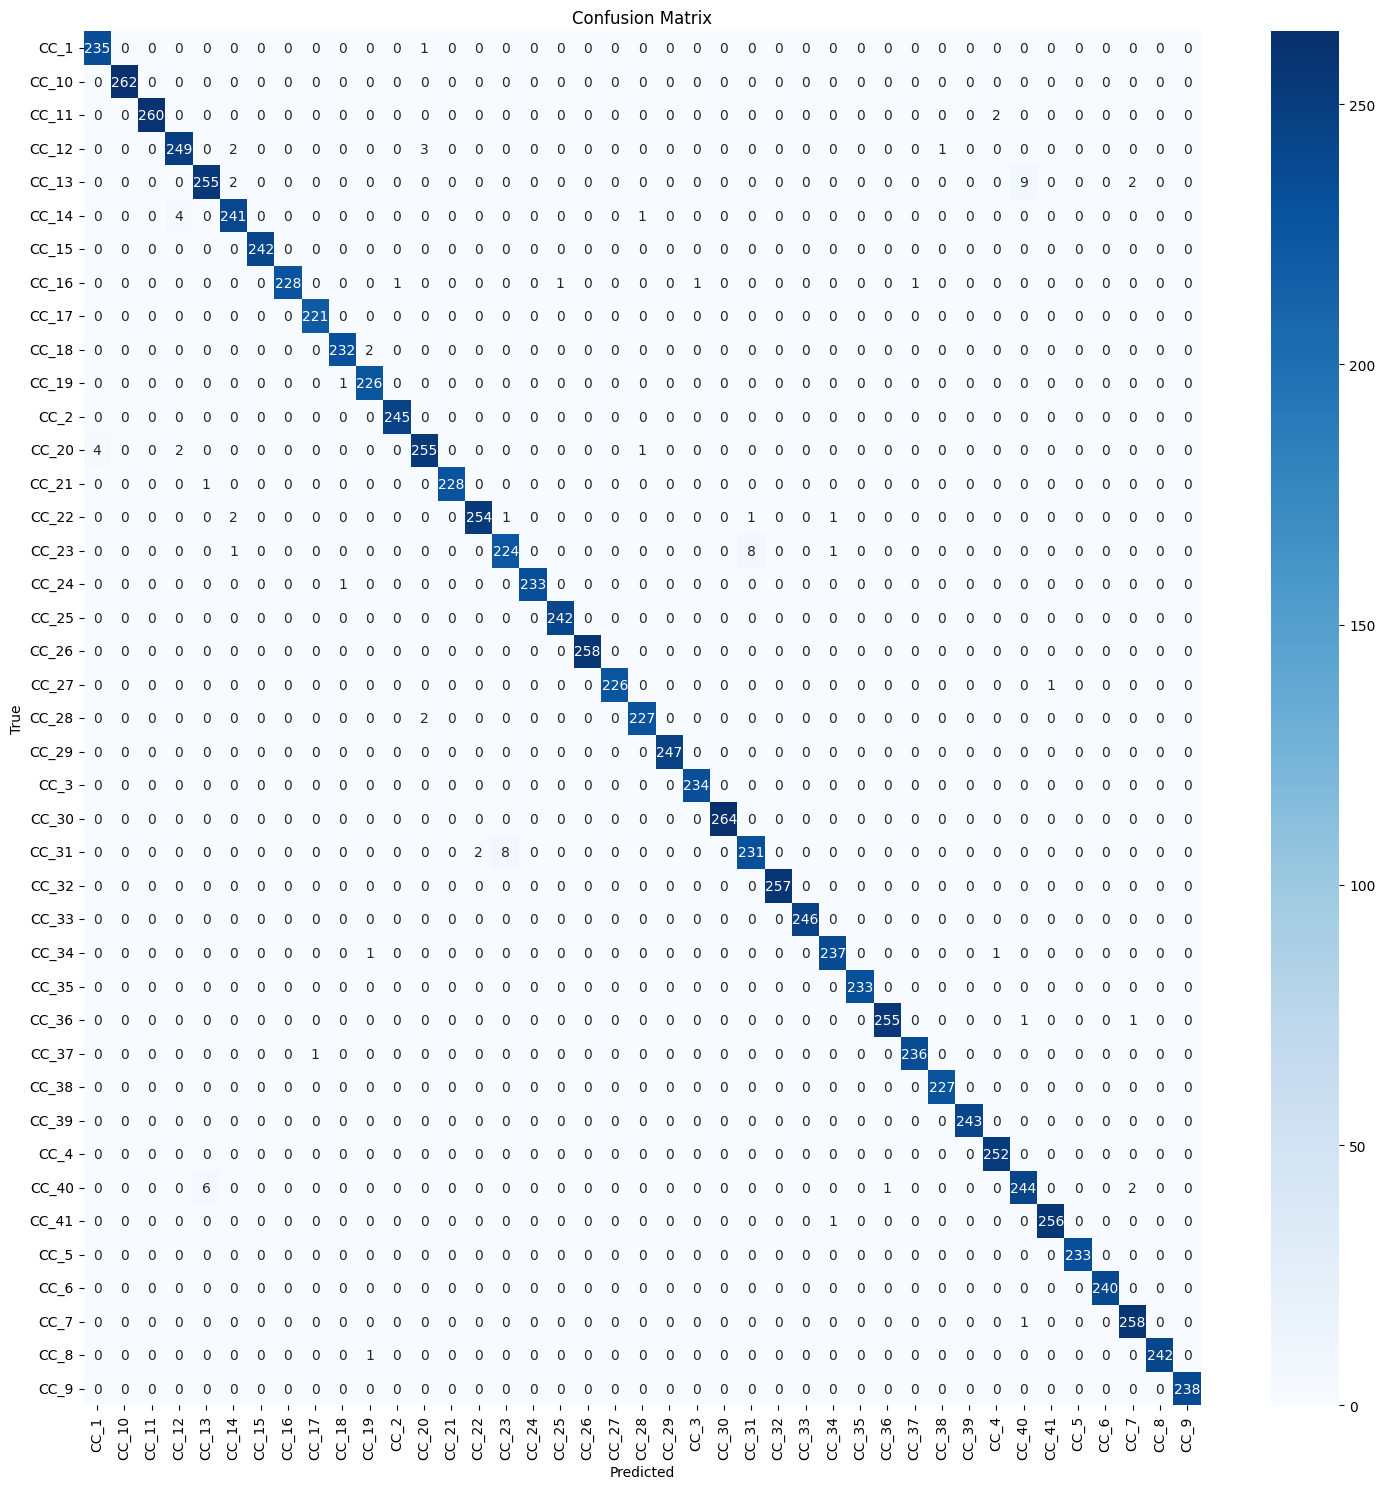

In [28]:
# Create a confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Store all predictions and true labels
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Get class names from the dataset
class_names = full_dataset.classes

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

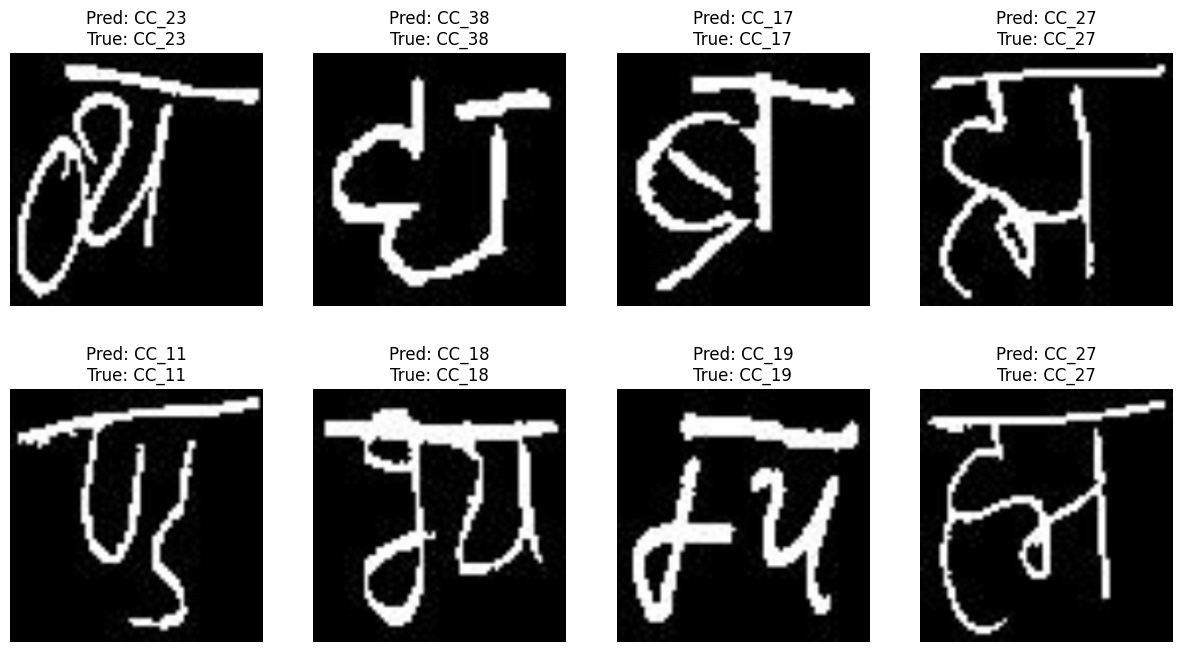

In [29]:
# Function to visualize predictions
def visualize_predictions(model, dataloader, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))
    
    class_names = dataloader.dataset.dataset.classes
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                ax.axis('off')
                
                # Convert back to original image for visualization
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485])
                std = np.array([0.229])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                # Convert grayscale to RGB for displaying
                if img.shape[2] == 1:
                    img = np.repeat(img, 3, axis=2)
                
                ax.imshow(img)
                
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Visualize some test predictions
visualize_predictions(model, test_loader)


In [30]:
# Evaluate the model and create a detailed classification report
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

def generate_classification_report(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Get class names from the dataset
    class_names = dataloader.dataset.dataset.classes
    
    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Print the detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)
    
    # Print the most challenging classes (lowest F1 scores)
    print("\nMost Challenging Classes (Lowest F1 Scores):")
    class_metrics = [(class_names[i], f1[i], support[i]) for i in range(len(class_names))]
    class_metrics.sort(key=lambda x: x[1])  # Sort by F1 score
    
    for class_name, f1_score, support_count in class_metrics[:5]:  # Show 5 hardest classes
        print(f"Class: {class_name}, F1-score: {f1_score:.4f}, Support: {support_count}")
    
    return all_labels, all_preds

# Run the evaluation on test set
print("\nDetailed Evaluation on Test Set:")
all_labels, all_preds = generate_classification_report(model, test_loader, device)


Detailed Evaluation on Test Set:
Overall Accuracy: 0.9912

Classification Report:
              precision    recall  f1-score   support

        CC_1     0.9833    0.9958    0.9895       236
       CC_10     1.0000    1.0000    1.0000       262
       CC_11     1.0000    0.9924    0.9962       262
       CC_12     0.9765    0.9765    0.9765       255
       CC_13     0.9733    0.9515    0.9623       268
       CC_14     0.9718    0.9797    0.9757       246
       CC_15     1.0000    1.0000    1.0000       242
       CC_16     1.0000    0.9828    0.9913       232
       CC_17     0.9955    1.0000    0.9977       221
       CC_18     0.9915    0.9915    0.9915       234
       CC_19     0.9826    0.9956    0.9891       227
        CC_2     0.9959    1.0000    0.9980       245
       CC_20     0.9770    0.9733    0.9751       262
       CC_21     1.0000    0.9956    0.9978       229
       CC_22     0.9922    0.9807    0.9864       259
       CC_23     0.9614    0.9573    0.9593       23

In [31]:
# Save the model
model_save_path = 'devanagri_conjunct_resnet50.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to devanagri_conjunct_resnet50.pth


In [32]:
from IPython.display import FileLink
FileLink(r'devanagri_conjunct_resnet50.pth')

/kaggle/working/devanagri_conjunct_resnet50.pth